## import statements

In [1]:
import altair as alt
import numpy as np
import pandas as pd

In [2]:
trem_list = pd.read_pickle('../data/tremor/aghosh.pkl')

In [3]:
tremors = trem_list[0]

In [4]:
date = pd.DataFrame({'year': tremors['Year'], 'month': tremors['Month'], 'day': tremors['Day'], \
    'hour': tremors['Hour'], 'minute': tremors['Minute'], 'second': np.zeros(tremors.shape[0])})
date = pd.to_datetime(date)

In [5]:
tremors = tremors.assign(Date = date)

In [6]:
tremors.head()

,Year,Month,Day,Hour,Minute,Latitude,Longitude,Depth,errLat,errLon,errDepth,Date
0,2009,6,20,1,26,48.232500,-123.065000,28.000000,10.423439,7.125217,17.262677,2009-06-20 01:26:00
1,2009,6,20,1,28,48.172500,-123.050000,23.750000,2.451065,1.355398,3.774917,2009-06-20 01:28:00
2,2009,6,20,9,20,48.453333,-123.066667,55.000000,9.907575,2.795187,7.000000,2009-06-20 09:20:00
3,2009,6,20,21,3,48.403333,-123.726667,53.333333,8.934842,11.118311,31.659648,2009-06-20 21:03:00
4,2009,6,21,0,42,48.030000,-122.875000,21.000000,4.328503,7.153370,12.909944,2009-06-21 00:42:00


In [7]:
aug16 = tremors[(tremors['Year']==2010)&(tremors['Month']==8)&(tremors['Day']==17)]

In [8]:
aug16.head()

,Year,Month,Day,Hour,Minute,Latitude,Longitude,Depth,errLat,errLon,errDepth,Date
18239,2010,8,17,0,1,48.0575,-122.990000,42.500000,1.390931,0.607511,3.872983,2010-08-17 00:01:00
18240,2010,8,17,0,2,47.9600,-123.017500,23.750000,1.276406,1.411121,5.795113,2010-08-17 00:02:00
18241,2010,8,17,0,4,47.8600,-122.827500,66.500000,3.721331,7.016445,13.403980,2010-08-17 00:04:00
18242,2010,8,17,0,5,47.9000,-122.806667,62.333333,8.731960,7.322551,5.537749,2010-08-17 00:05:00
18243,2010,8,17,0,7,47.7850,-123.062500,59.000000,4.557681,5.086782,26.758176,2010-08-17 00:07:00


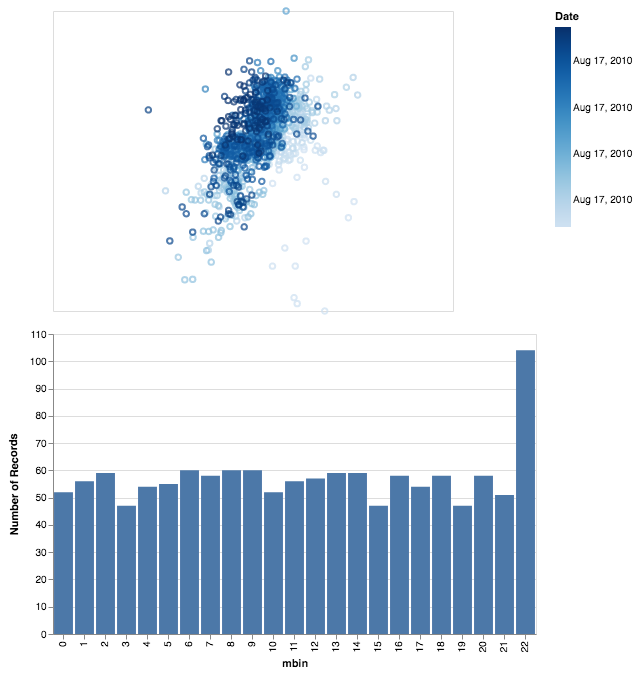

In [9]:
brush = alt.selection(type='interval', encodings=['x'])

points = alt.Chart().mark_point().encode(
    longitude = 'Longitude',
    latitude = 'Latitude',
    color='Date'
).transform_filter(
    brush.ref()
)

bars = alt.Chart().mark_bar().encode(
    x= 'mbin:N',
    y='count()'
).properties(
    selection=brush
)

alt.vconcat(points, bars,
    data=aug16
).transform_bin(
    "mbin",
    field="Hour",
    bin=alt.Bin(maxbins=25)
)

Set the numbers of minutes to be binned

In [10]:
nmin = 10
smin = str(nmin) + 'T'

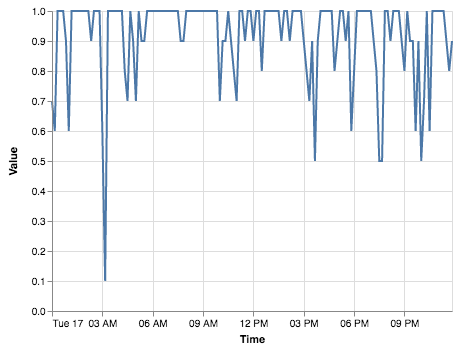

In [11]:
df = pd.DataFrame({'Time': aug16['Date'], 'Value': np.repeat(1, aug16.shape[0])})
df.set_index('Time', inplace=True)
df.tail()
df_group = df.groupby(pd.Grouper(level='Time', freq=smin))['Value'].agg('sum')   
df_group.dropna(inplace=True)
df_group = df_group.to_frame().reset_index()
df_group['Value'] = (1.0 / nmin) * df_group['Value']

alt.Chart(df_group).mark_line().encode(
    x='Time',
    y='Value'
)

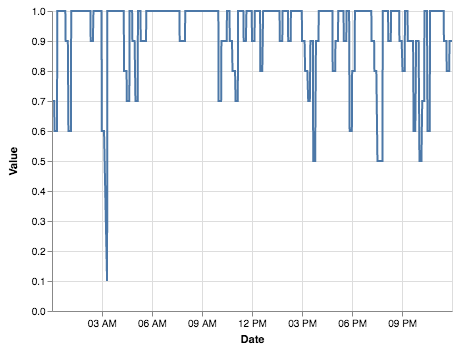

In [12]:
dfInterp = pd.merge_asof(aug16.sort_values(by="Date"), df_group.sort_values(by="Time"), \
    left_on="Date",right_on="Time")

alt.Chart(dfInterp).mark_line().encode(
    x='Date',
    y='Value'
)

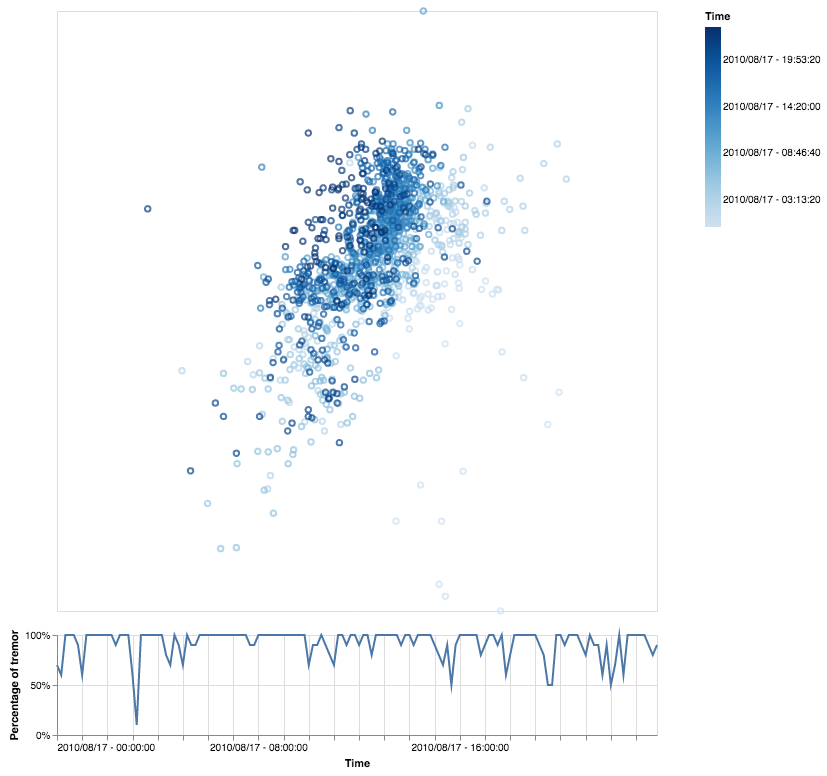

In [13]:
brush = alt.selection(type='interval', encodings=['x'])

points = alt.Chart().mark_point().encode(
    longitude = 'Longitude',
    latitude = 'Latitude',
    color=alt.Color('Time', legend=alt.Legend(format='%Y/%m/%d - %H:%M:%S'))
).transform_filter(
    brush.ref()
).properties(
    width=600,
    height=600
)

bars = alt.Chart().mark_line().encode(
    x=alt.X('Time', axis=alt.Axis(format='%Y/%m/%d - %H:%M:%S', title='Time')),
    y=alt.Y('Value', axis=alt.Axis(format='%', title='Percentage of tremor'))
).properties(
    width=600,
    height=100,
    selection=brush
)

alt.vconcat(points, bars,
    data=dfInterp
)